# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [ ]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from velocereduction import config
import velocereduction as VR

from astropy.table import Table
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [ ]:
starting_memory = VR.utils.get_memory_usage()
print('Memory before starting the reduction:')
print(starting_memory)

## Adjust Date and Directory (possibly via argument parser)

In [ ]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        jupyter_date = "001122" # Reference night
        
        # 2Amp example
        # jupyter_date = "240219"
        
        # 4Amp example
        # jupyter_date = "231121"

        # jupyter_date = "250706" # significant dX (-8.8) and dY (+2.8) in some CCDs wrt reference night

        jupyter_working_directory = "../"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date

if args.working_directory[:2] in ['./','~/']:
    config.working_directory = str(Path(args.working_directory).resolve())+'/'
else:
    config.working_directory = str(Path(args.working_directory).resolve())+'/'
print(f"Date: {config.date}, Working Directory: {config.working_directory}")

## Identfiy Calibration and Science Runs

In [ ]:
# Extract the Calibration and Science data from the night log

each_science_run_separately = True # Set this True, if you want to reduce the runs of the same object separately

calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(
    config.date,
    config.working_directory+'observations/',
    each_science_run_separately = each_science_run_separately
)

## Extract orders and save in initial FITS files with an extension per order.

In [ ]:
# Estimate the pixel shifts in x and y for each CCD with respect to the reference frames
if config.date == "001122":
    ccd_pixel_shifts_wrt_reference = {'ccd_1': (0.0, 0.0), 'ccd_2': (0.0, 0.0), 'ccd_3': (0.0, 0.0)}
elif config.date == "250706":
    ccd_pixel_shifts_wrt_reference = {'ccd_1': (-6.14, +1.12), 'ccd_2': (-8.68, +2.65), 'ccd_3': (+2.62, +0.06)} # <-- Correct shift!
else:
    ccd_pixel_shifts_wrt_reference = VR.extraction.estimate_ccd_pixel_shifts_wrt_reference(calibration_runs)

print(ccd_pixel_shifts_wrt_reference)


In [ ]:
# Extract Master Flat
print('\nExtracting Master Flat')
master_flat, master_flat_images = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['Flat_60.0'],
    ccd2_runs = calibration_runs['Flat_1.0'],
    ccd3_runs = calibration_runs['Flat_0.1'],
    Flat = True,
    update_tramlines_based_on_flat = False, # Refit saved in reduced_data/YYMMDD/_tramline_information/
    pixel_shifts = ccd_pixel_shifts_wrt_reference,
    debug_overscan = False,
    debug_rows = False, # Plotting the distribution of counts of a tramline in every 500th row
    debug_tramlines = False # Plots saved  at reduced_data/YYMMDD/_tramline_information/
)

# Extract Master ThXe
print('\nExtracting Master ThXe')
master_thxe = VR.extraction.extract_orders(
    ccd1_runs = calibration_runs['FibTh_180.0'],
    ccd2_runs = calibration_runs['FibTh_60.0'],
    ccd3_runs = calibration_runs['FibTh_15.0'],
    ThXe = True,
    master_flat_images = master_flat_images,
    pixel_shifts = ccd_pixel_shifts_wrt_reference,
    debug_tramlines = False # Plots saved  at reduced_data/YYMMDD/_tramline_information/
)

# Extract Master LC
if len(calibration_runs['SimLC']) > 0:
    print('\nExtracting Master LC')
    master_lc = VR.extraction.extract_orders(
        ccd1_runs = calibration_runs['SimLC'],
        ccd2_runs = calibration_runs['SimLC'],
        ccd3_runs = calibration_runs['SimLC'],
        LC = True,
        master_flat_images = master_flat_images,
        debug_tramlines = False # Plots saved  at reduced_data/YYMMDD/_tramline_information/
    )
else:
    print('\nNo SimLC observed for this night; Skipping Master LC calibration and setting all values 0.0')
    master_lc = master_thxe.copy(); master_lc[:] = 0.0

# Extract Darks
master_darks = dict()
if len(calibration_runs['Darks']) > 0:
    print('\nExtracting Darks')
    for dark_exposure in calibration_runs['Darks'].keys():
        print('  --> '+str(dark_exposure)+': '+','.join(calibration_runs['Darks'][dark_exposure]))
        master_darks[dark_exposure] = VR.extraction.get_master_dark(calibration_runs['Darks'][dark_exposure])
else:
    print('\nNo Dark exposure found for '+config.date+'. Using Archvial exposure from 001122 (2Amp.)')
    master_darks['1800.0'] = VR.extraction.get_master_dark(calibration_runs['Darks'], archival=True)

# Extract BStars -> Telluric lines
master_bstars = dict()
if len(calibration_runs['Bstar']) > 0:
    print('\nExtracting Bstar-Tellurics')
    for bstar_exposure in calibration_runs['Bstar'].keys():
        print('  --> '+str(bstar_exposure)+': '+', '.join(calibration_runs['Bstar'][bstar_exposure]))
        telluric_flux, telluric_mjd = VR.extraction.get_tellurics_from_bstar(
            calibration_runs['Bstar'][bstar_exposure], master_flat_images,
            debug = False
        )
        master_bstars[telluric_mjd] = telluric_flux

In [ ]:
# Extract Science Objects and save them into FITS files under reduced_data/
for science_object in list(science_runs.keys()):
    print('\nExtracting '+science_object)

#     try:
    science, science_noise, science_header = VR.extraction.extract_orders(
        ccd1_runs = science_runs[science_object],
        ccd2_runs = science_runs[science_object],
        ccd3_runs = science_runs[science_object],
        Science=True,
        master_darks = master_darks, # These are needed to subtract the dark current
        master_flat_images = master_flat_images, # These are needed for flat-field correction
        debug_tramlines = False # Plots saved  at reduced_data/YYMMDD/_tramline_information/
    )

    # Find the closest BStar calibration
    if len(master_bstars) > 0:
        mjd_science = science_header['UTMJD']
        mjd_tellurics = np.array(list(master_bstars.keys()))
        closest_tellurics = mjd_tellurics[np.argmin(np.abs(mjd_tellurics - mjd_science))]
        print(f'  --> Using telluric from B Star as observed at UTMJD {closest_tellurics} (Science taken at UTMJD {mjd_science})')
        telluric = master_bstars[closest_tellurics]
    else:
        print('No tellurics from B Stars available.')
        telluric = np.ones(np.shape(science))

    # Create a primary HDU and HDU list
    primary_hdu = fits.PrimaryHDU()
    header = primary_hdu.header
    header['OBJECT']             = (science_object,           'Name of observed object in night log')
    header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
    header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
    header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
    header['BARYVEL']            = (0.0,                      'Applied barycentric velocity correction')
    header['VRAD']               = ('None',                   'Radial velocity estimate')
    header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')

    # Use astroquery to update header with Simbad information (where available)
    # We try to find matches with HIP/2MASS/Gaia DR3 as well as
    # radial velocities (VRAD), stellar parameters (TEFF/LOGG/FE_H), and 
    # magnitudes in B/V/G/R as well as parallax PLX
    header = VR.utils.update_fits_header_via_crossmatch_with_simbad(header)

    hdul = fits.HDUList([primary_hdu])

    # Figure out which extensions have been extracted into the arrays
    order_ranges, order_beginning_coeffs, order_ending_coeffs = VR.extraction.read_in_order_tramlines()

    # Loop over your extension names and corresponding data arrays
    for ext_index, ext_name in enumerate(order_beginning_coeffs):
        # Create an ImageHDU object for each extension

        # Define the columns with appropriate formats
        col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
        col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
        col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
        col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
        col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
        col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:])
        col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:])
        col8_def = fits.Column(name='telluric',format='E', array=telluric[ext_index,:])

        # Combine columns to BinTable and add header from primary
        hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def, col8_def], name=ext_name.lower())

        # Append the HDU to the HDU list
        hdul.append(hdu)

    # Save to a new FITS file with an extension for each order
    Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
    spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
    hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

    print('\n  --> Successfully extracted '+science_object)

#     except:
#         print('\n  --> Failed to extract '+science_object)

Calibrating wavelength for HIP56343_0113
  --> Correcting for barycentric velocity: -15.98 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [-1.81]
  --> $v_\mathrm{rad}  = -4.49 \pm 0.54 \pm 1.64\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 7 lines.


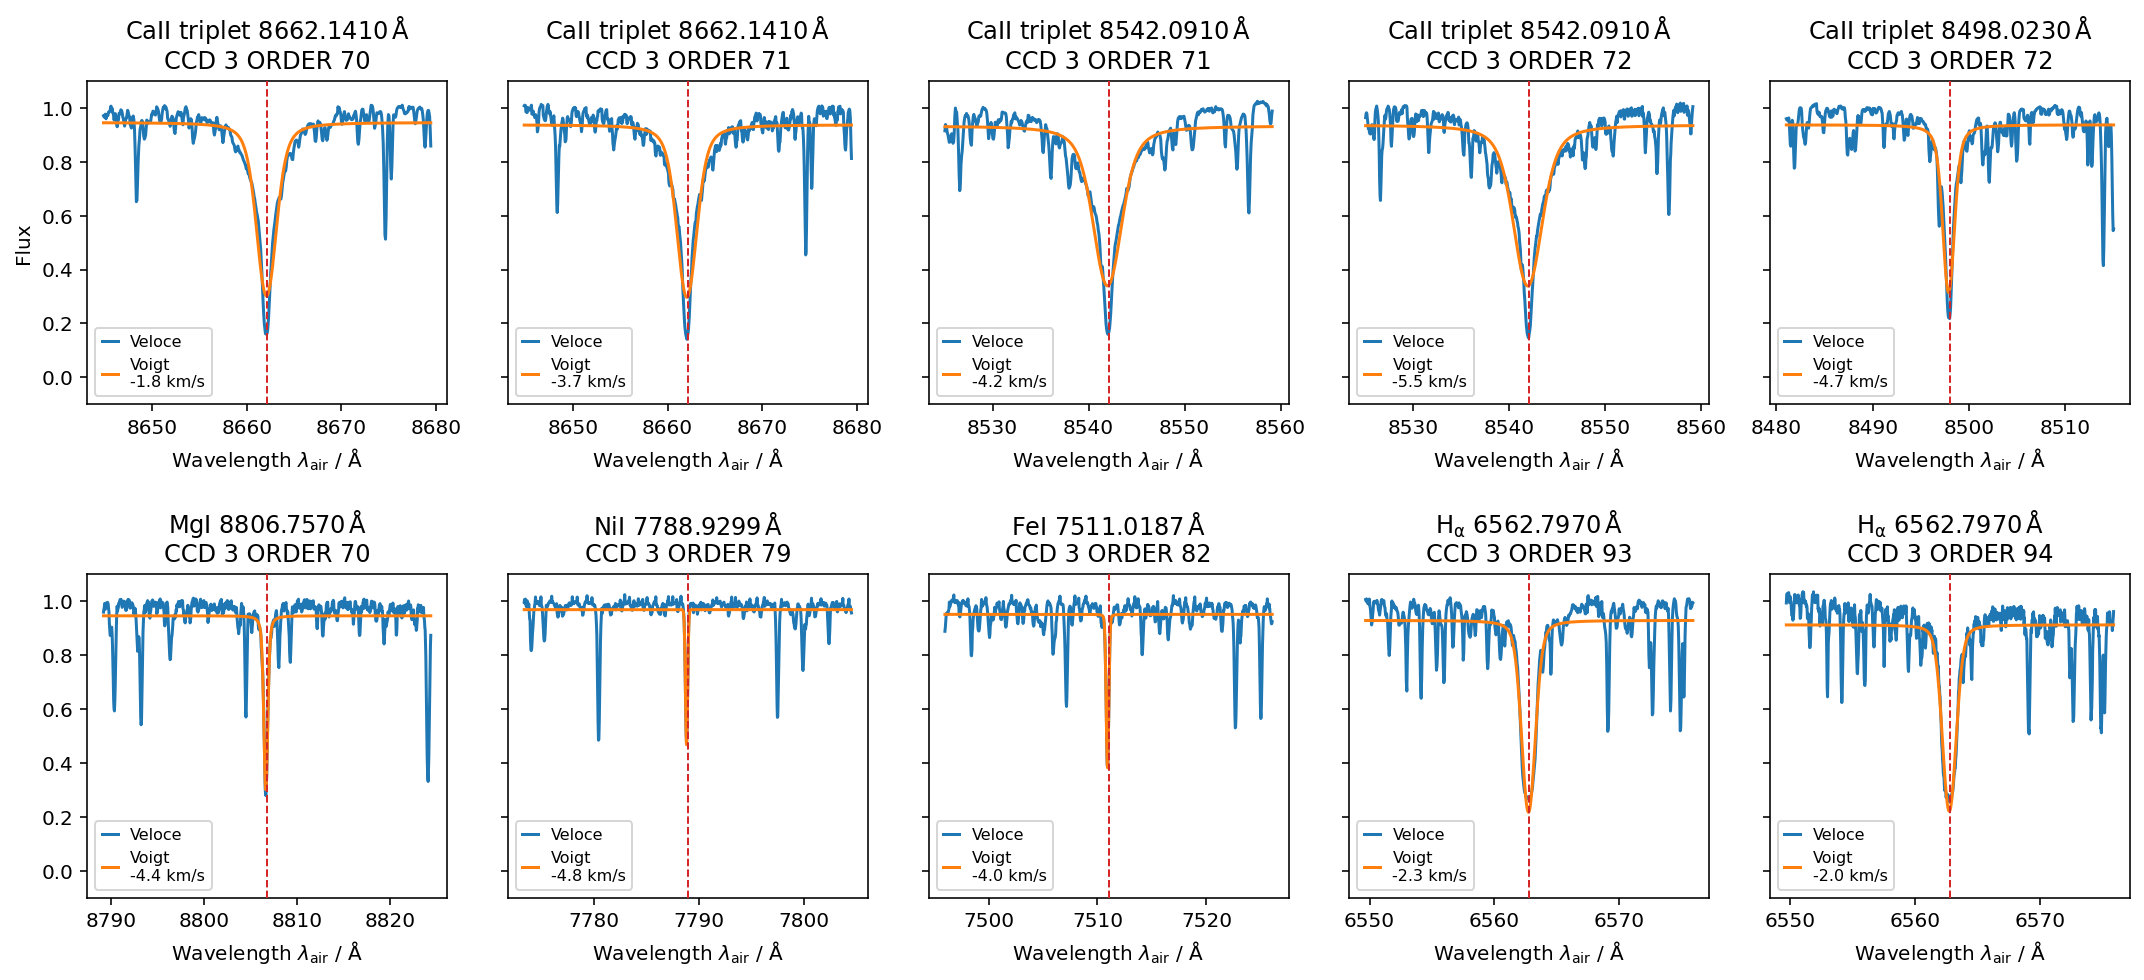

  --> Not creating overview PDF.

Calibrating wavelength for HIP56343_0114
  --> Correcting for barycentric velocity: -15.97 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [-1.82]
  --> $v_\mathrm{rad}  = -4.49 \pm 0.52 \pm 1.64\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 7 lines.


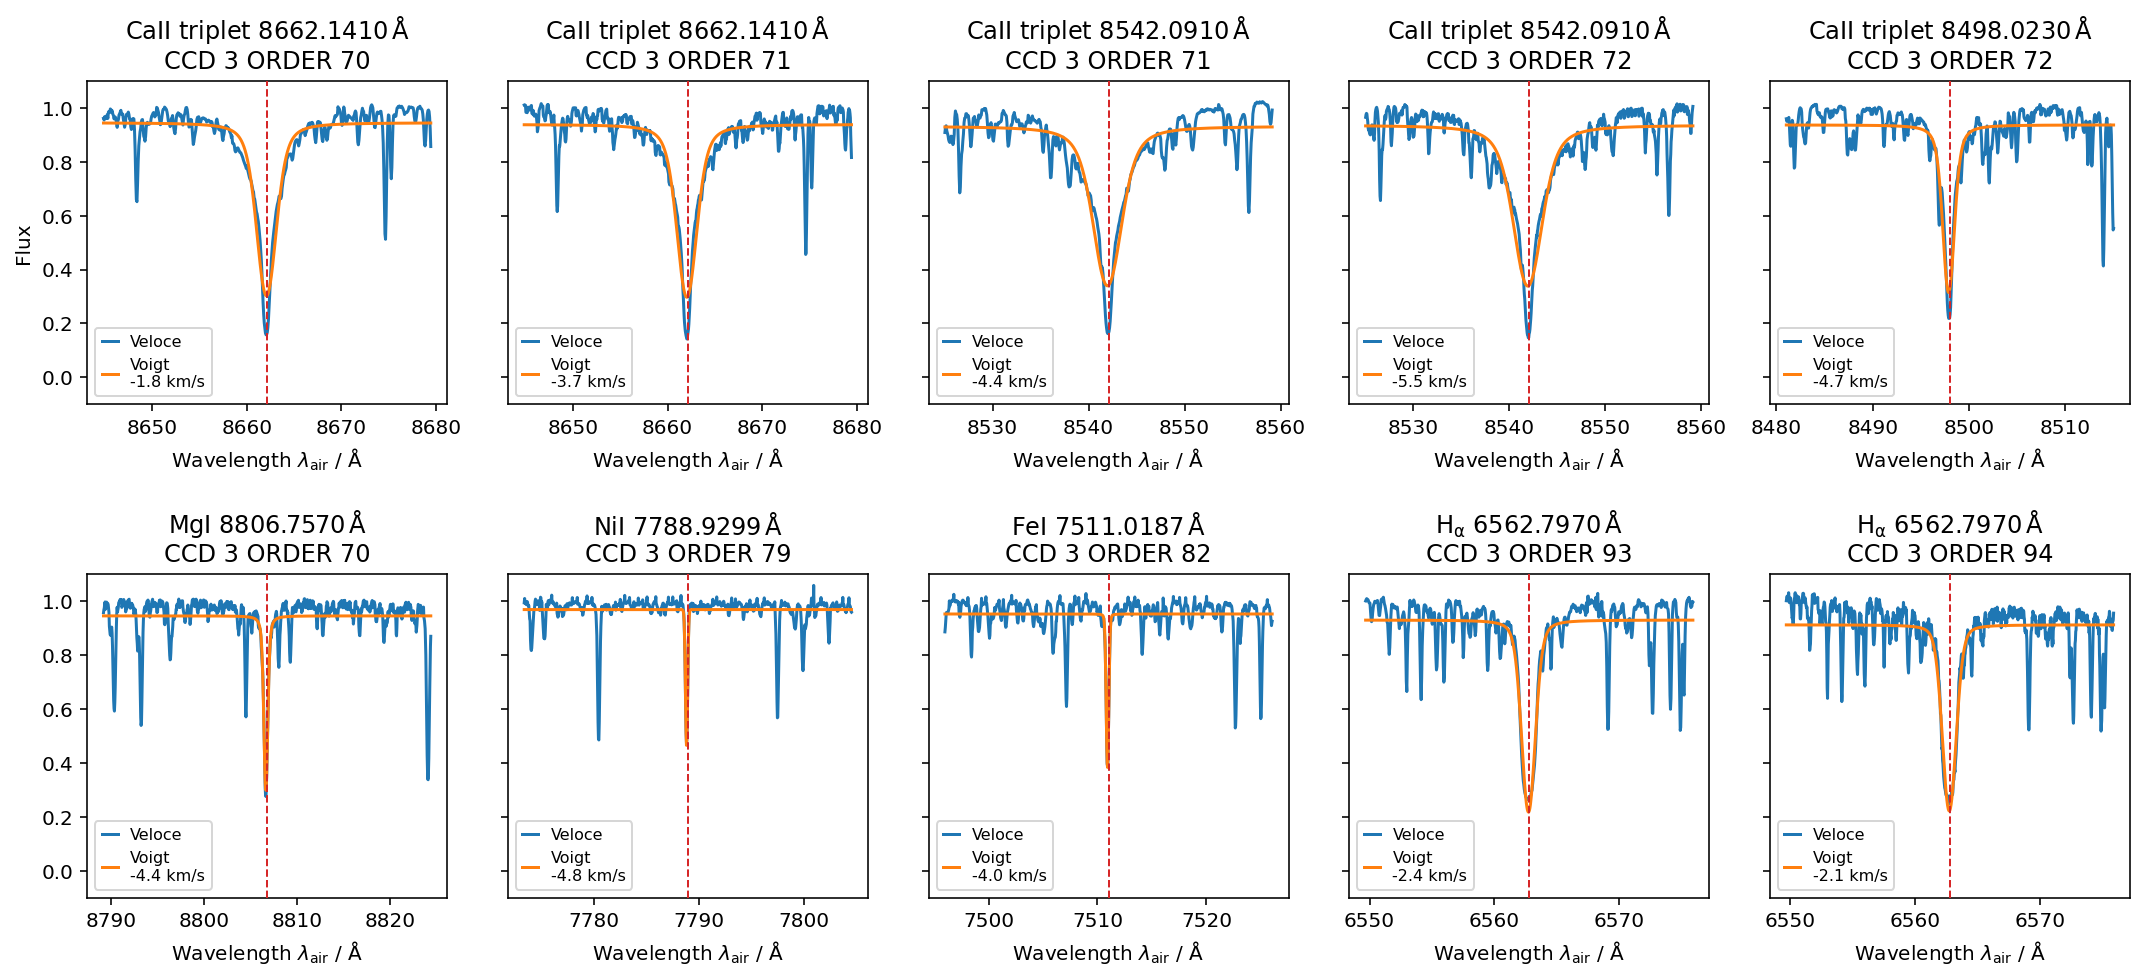

  --> Not creating overview PDF.

Calibrating wavelength for HIP57757_0117
  --> Correcting for barycentric velocity: -14.00 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Neglecting RV estimate for NiI 7788.9299 due to weak line (EW 7 < 100 mÅ).
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [7.41]
  --> $v_\mathrm{rad}  = 4.69 \pm 0.53 \pm 1.54\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 6 lines.


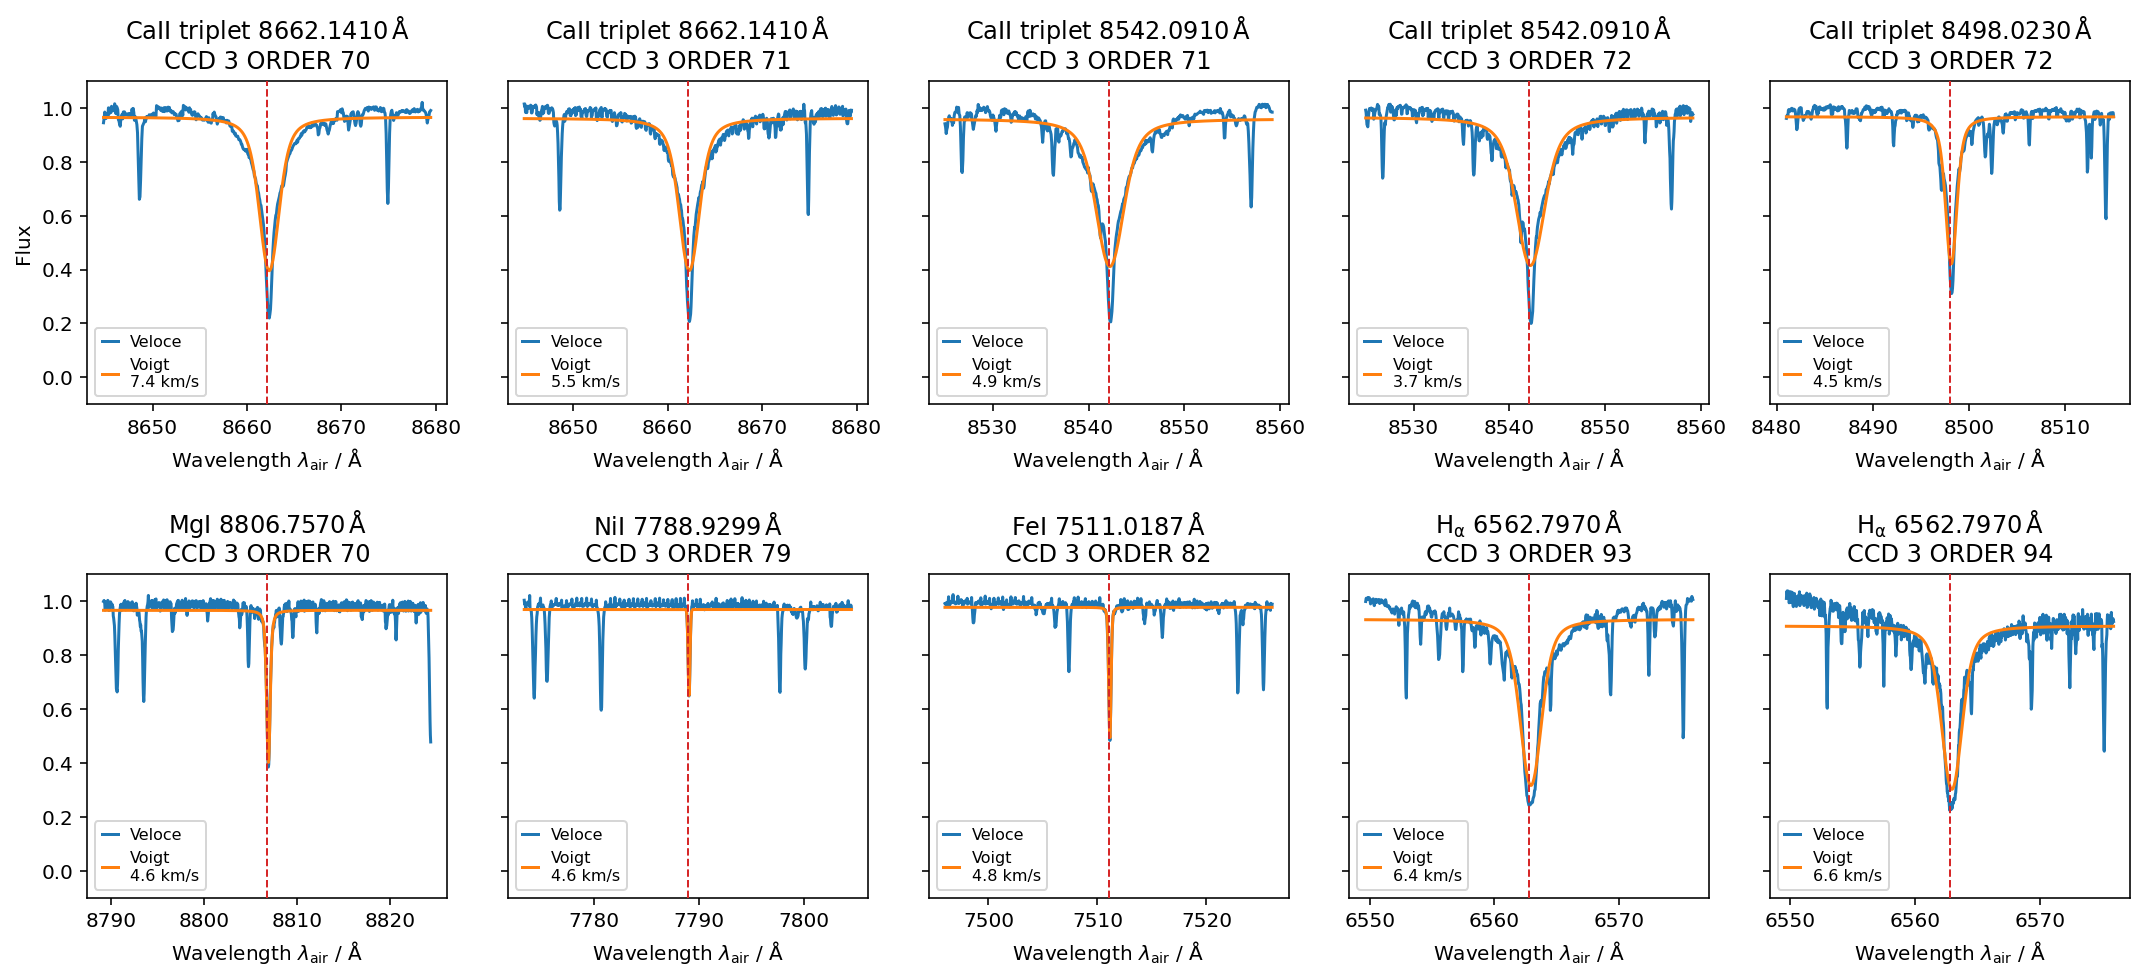

  --> Not creating overview PDF.

Calibrating wavelength for HIP57757_0118
  --> Correcting for barycentric velocity: -13.99 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Neglecting RV estimate for NiI 7788.9299 due to weak line (EW 7 < 100 mÅ).
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [7.56]
  --> $v_\mathrm{rad}  = 4.73 \pm 0.57 \pm 1.55\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 6 lines.


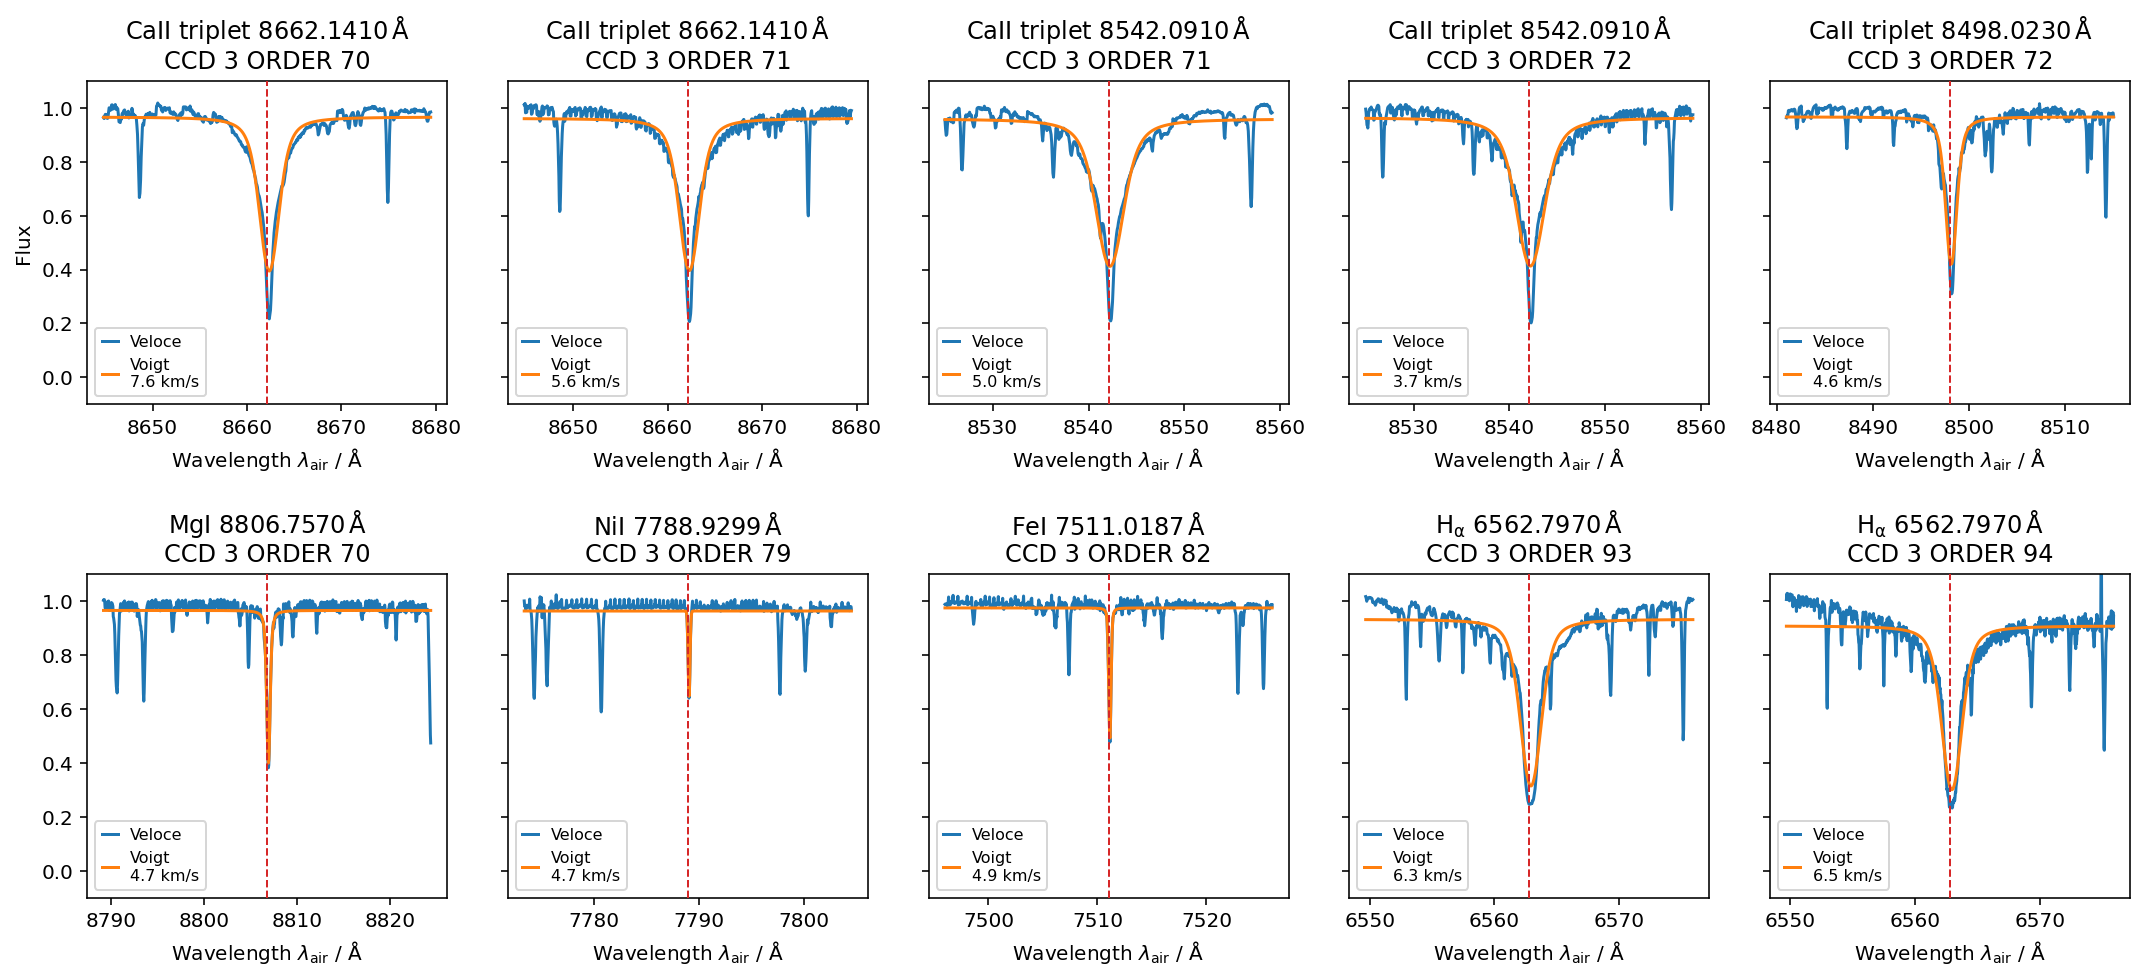

  --> Not creating overview PDF.

Calibrating wavelength for HIP69673_0150
  --> Correcting for barycentric velocity: -21.08 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [-2.72]
  --> $v_\mathrm{rad}  = -5.01 \pm 0.48 \pm 1.52\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 7 lines.


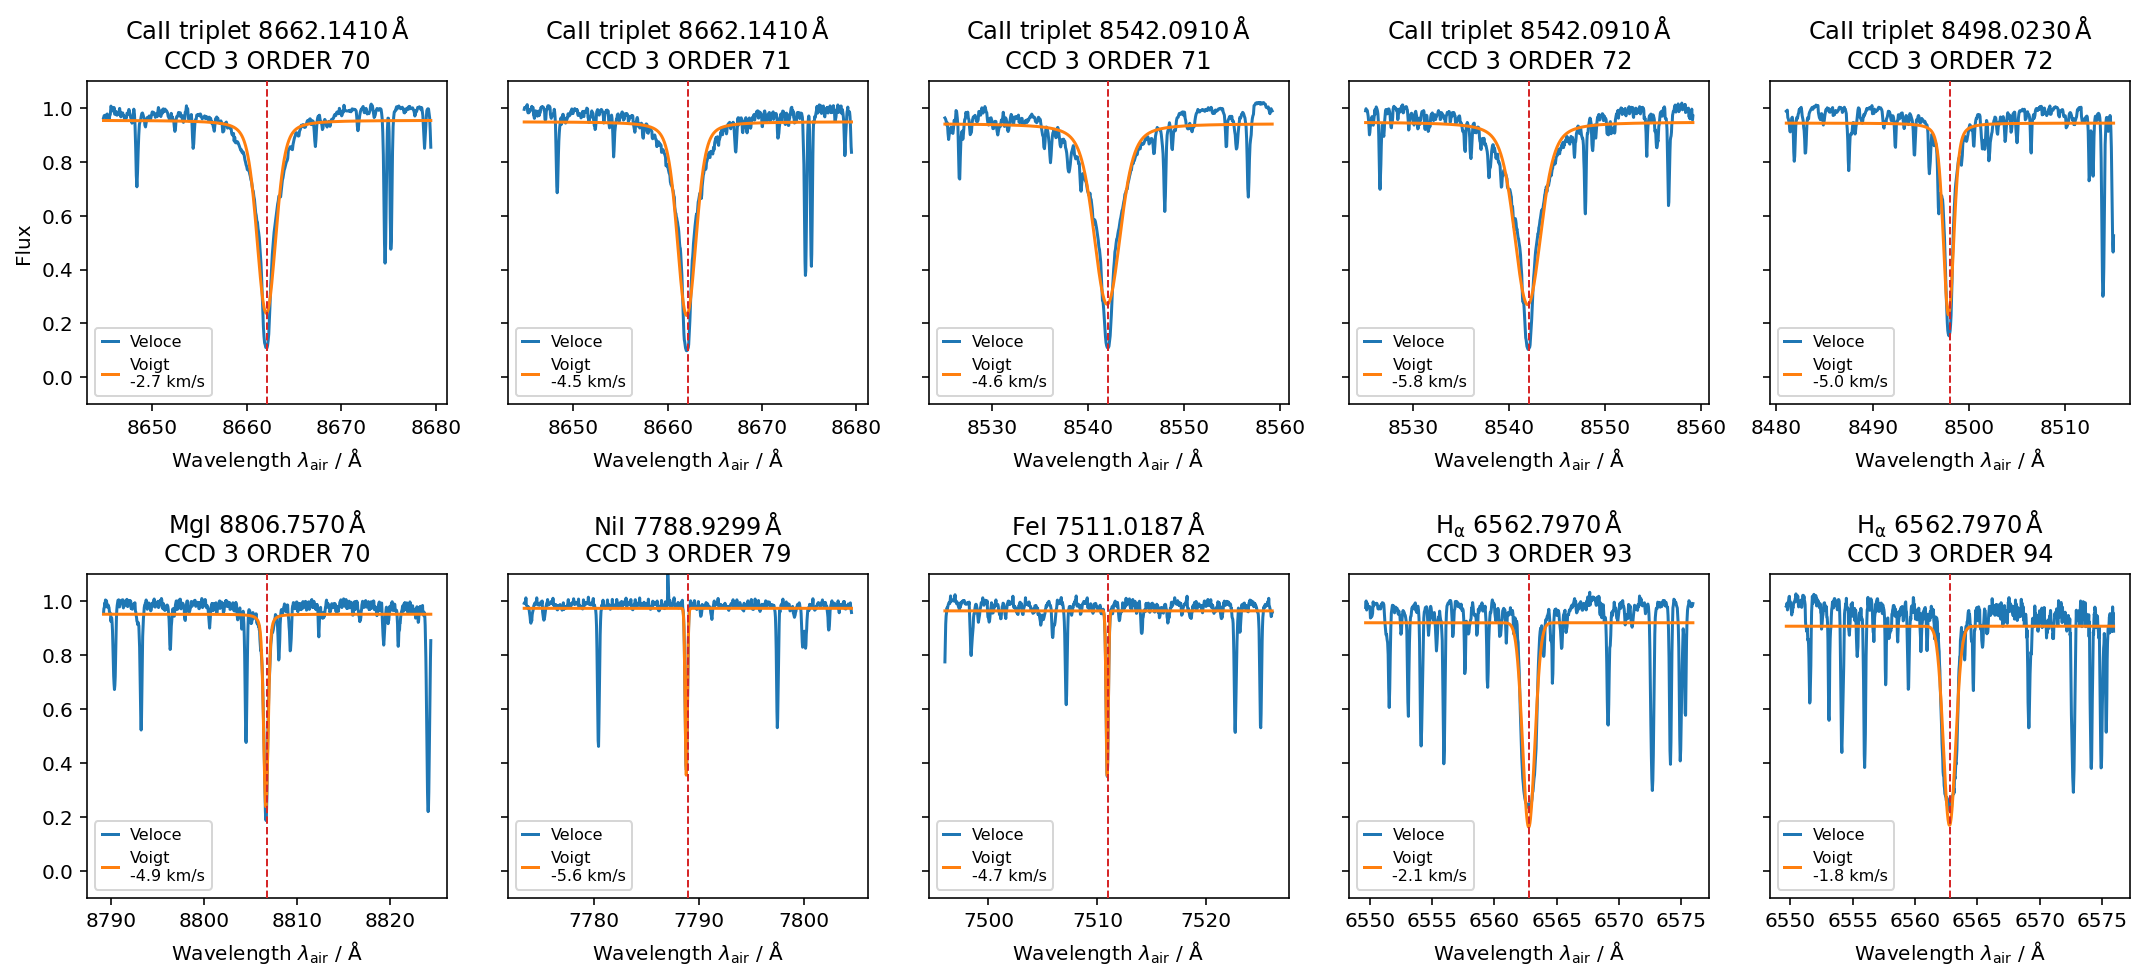

  --> Not creating overview PDF.

Calibrating wavelength for HIP69673_0151
  --> Correcting for barycentric velocity: -21.07 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 1 RV outlier(s):  [-2.44]
  --> $v_\mathrm{rad}  = -4.96 \pm 0.5 \pm 1.53\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 7 lines.


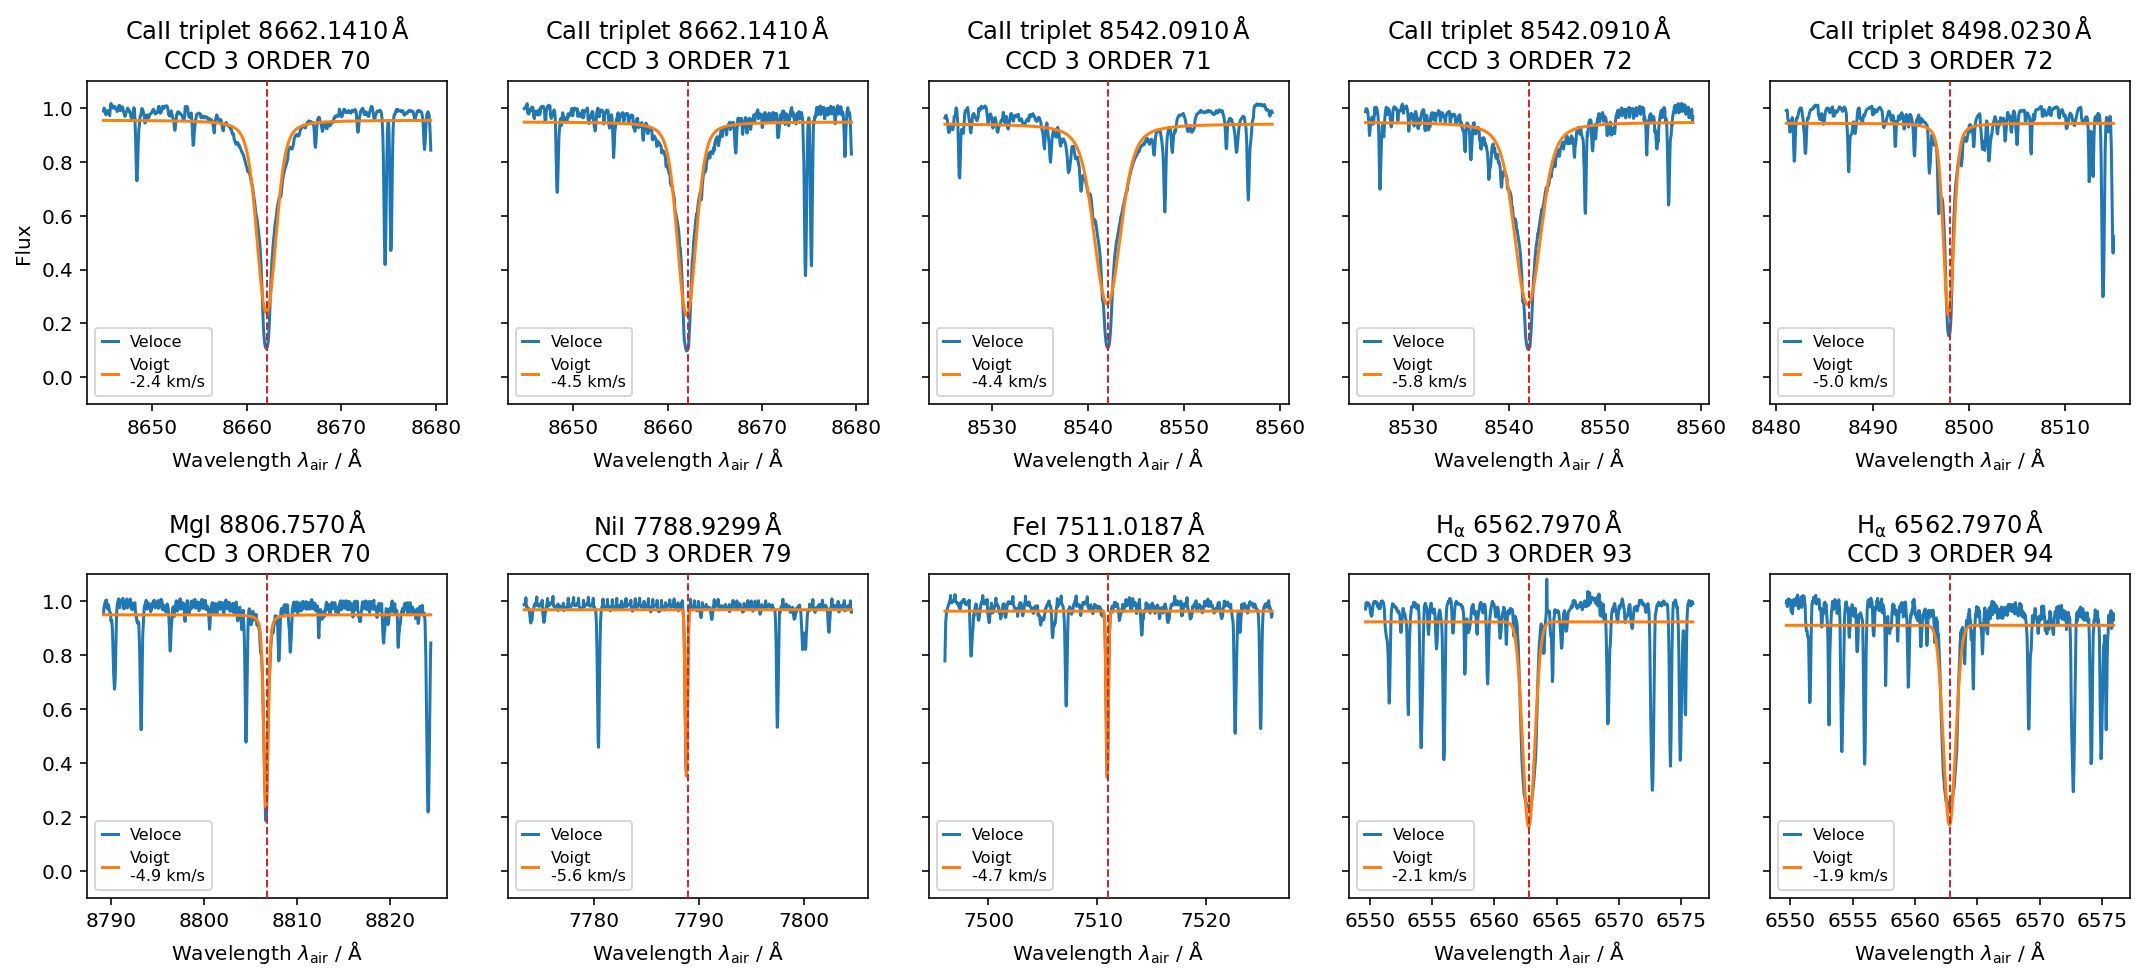

  --> Not creating overview PDF.

Calibrating wavelength for HD127972_0154
  --> Correcting for barycentric velocity: -26.81 km/s
  --> Using previous LC and ThXe calibrations as wavelength solution

  --> Estimating rough RV from Halpha and CaT; starting with CaII 8662 using its RV as initial guess for others.
  --> Warning: Voigt profile fit for 7788.9299 hit boundary of 400 km/s. Resetting RV to 0 km/s.
  --> Neglecting RV estimate for NiI 7788.9299 due to weak line (EW 0 < 100 mÅ).
  --> Warning: Voigt profile fit for 7511.0187 hit boundary of 400 km/s. Resetting RV to 0 km/s.
  --> Fitting Halpha, but neglecting for RV estimate.
  --> Neglecting 3 RV outlier(s):  [168.98 489.48   0.  ]
  --> $v_\mathrm{rad}  = 107.2 \pm 7.31 \pm 8.43\,\mathrm{km\,s^{-1}}$ (mean, scatter, unc.) based on 4 lines.


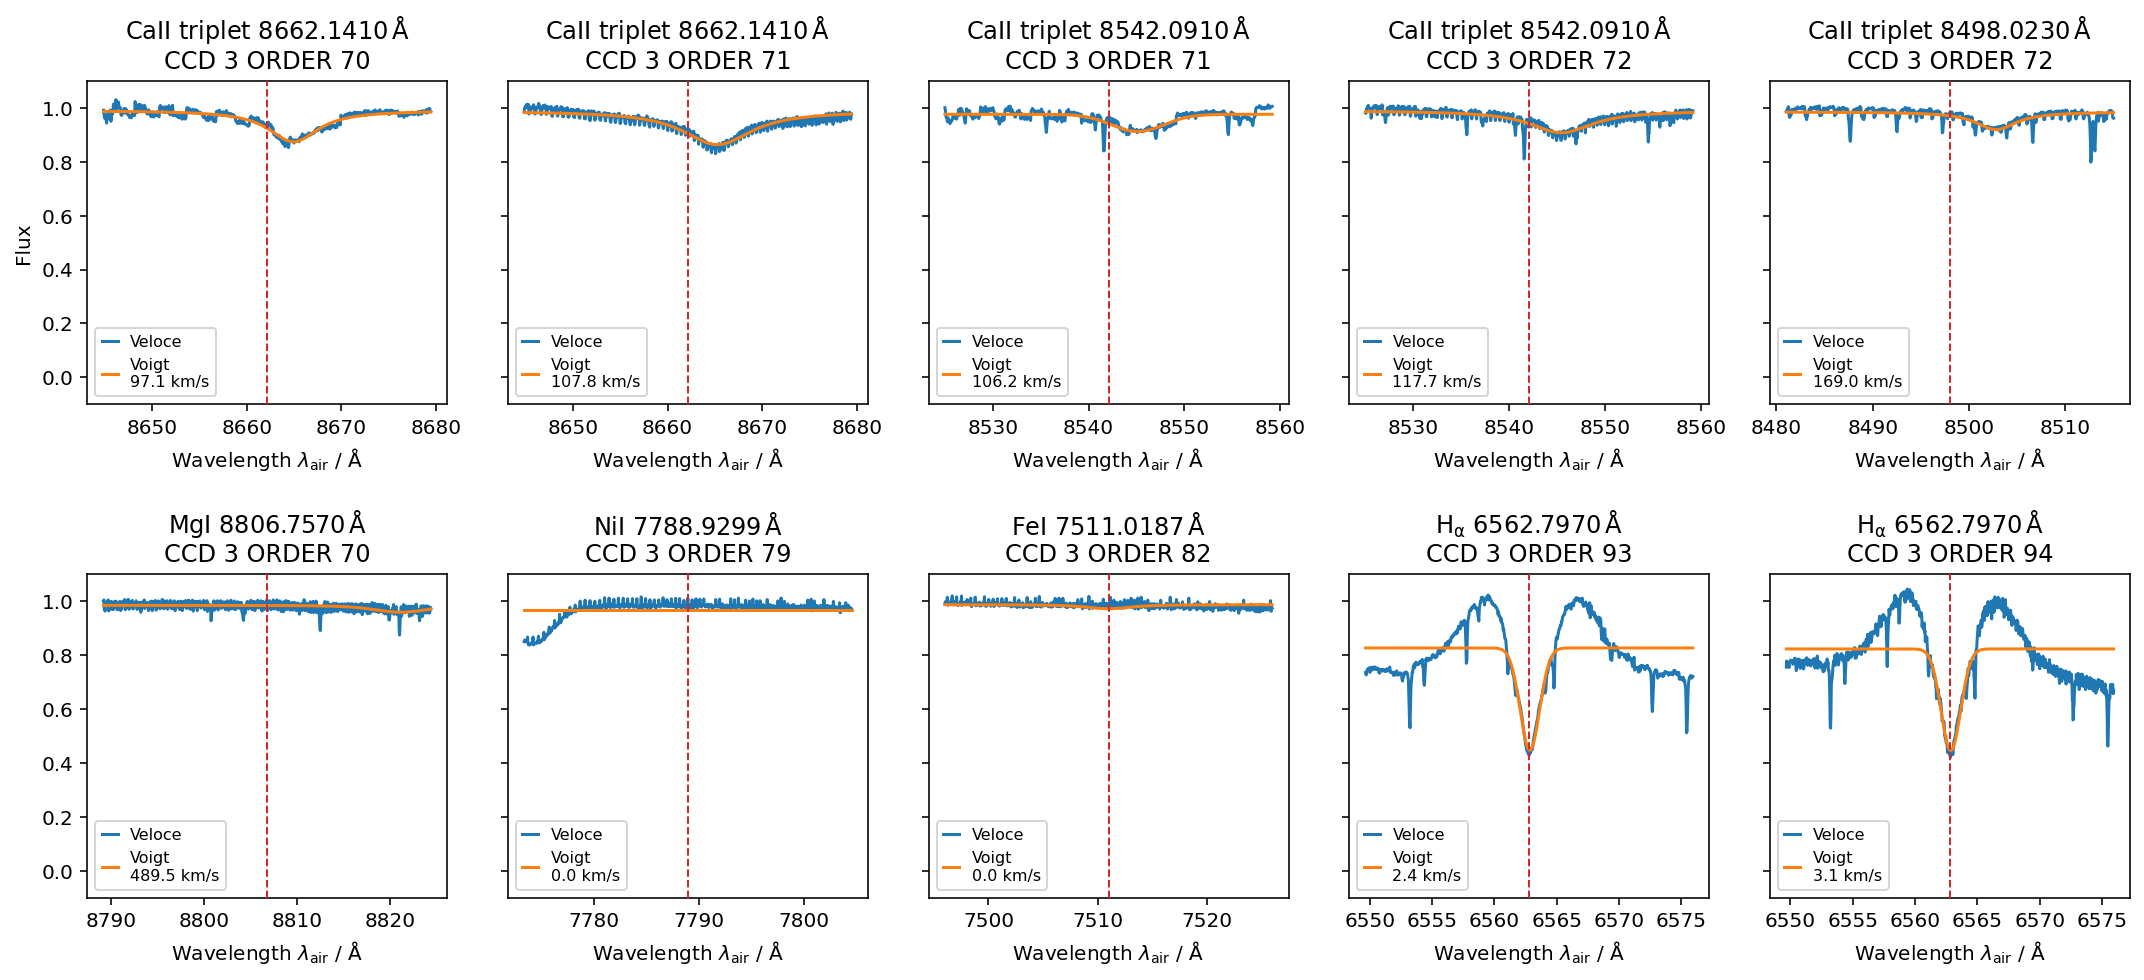

  --> Not creating overview PDF.



In [10]:
for science_object in list(science_runs.keys()):
#     try:
    VR.calibration.calibrate_wavelength(
        science_object,
        optimise_lc_solution=False,
        correct_barycentric_velocity=True,
        create_overview_pdf=False,
        fit_voigt_for_rv = True
    )
#         print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object+'\n')
#     except:
#         print('  -> Failed to calibrate wavelength for '+science_object+'\n')

## Wavelength calibration scripts for master wavelength calibration

### LC calibration with peak fitting

In [ ]:
# For LC optimisation

# for science_object in list(science_runs.keys())[:1]:
#     print(science_object)
#     file = fits.open('../reduced_data/'+config.date+'/'+science_object+'/veloce_spectra_'+science_object+'_'+config.date+'.fits')
#     # VR.calibration.calibrate_wavelength(science_object, optimise_lc_solution = True, fit_voigt_for_rv = False, debug = True)
#     for order_index in range(1,len(file)):
#         order_name = file[order_index].header['EXTNAME'].lower()
#         if (
#             order_name == 'ccd_2_order_136'
#             # ((order_name[4] == '3'))
#             # (order_name == 'ccd_3_order_77')
#             # ((order_name[4] == '3') & (order_name != 'ccd_3_order_65')) |
#             # # Let's use the last 2 digits to avoid warnings, because not all of CCD3 are > 100 (but all of CCD2).
#             # ((order_name[4] == '2') & (int(order_name[-2:]) >= 3) & (int(order_name[-2:]) <= 34))
#         ):
#             # try:
#             coeffs_lc = VR.calibration.optimise_wavelength_solution_with_laser_comb(
#                 order_name = order_name,
#                 lc_pixel_values = file[order_name].data['LC'],
#                 overwrite = True,
#                 plot_peak_fits = False,
#                 rejection = 'm/s', # options: auto, none, outliers, left100, right100, km/s, m/s
#                 debug = True
#             )
#             # except:
#             #     pass

### Calibration with synthetic spectra of RV standard HIP56343 for 001122

In [ ]:
# for science_object in list(science_runs.keys())[:1]:
#     print('\nCalibrating wavelength for '+science_object+' with given radial velocity and synthetic Korg spectrum')
#     with fits.open(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/veloce_spectra_'+science_object+'_'+config.date+'.fits', mode='update') as veloce_fits_file:
#         korg_spectra = VR.flux_comparison.read_available_korg_syntheses()
#         # Find the closest match based on (possibly available) literature TEFF/LOGG/FE_H
#         closest_korg_spectrum = VR.flux_comparison.find_closest_korg_spectrum(
#             available_korg_spectra = korg_spectra,
#             fits_header = veloce_fits_file[0].header,
#         )
#         closest_korg_spectrum = 'arcturus'
#         # Find the best RV or raise ValueError of none available.
#         # vrad_for_calibration = VR.utils.find_best_radial_velocity_from_fits_header(fits_header = veloce_fits_file[0].header)
#         vrad_for_calibration = -4.5990
#         # Let's test this for a few orders (or simply set order_selection = None to use all valid ones)
#         # orders_to_calibrate = ['ccd_1_order_139']
#         orders_to_calibrate = [
#             'ccd_1_order_163', 
#             'ccd_1_order_164', 
#             'ccd_1_order_165', 
#             'ccd_1_order_166', 
#             'ccd_1_order_167'
#             ]
#         VR.flux_comparison.calculate_wavelength_coefficients_with_korg_synthesis(
#             veloce_fits_file,
#             korg_wavelength_vac = korg_spectra['wavelength_vac'],
#             korg_flux = korg_spectra['flux_'+closest_korg_spectrum],
#             vrad_for_calibration = vrad_for_calibration,
#             order_selection=orders_to_calibrate,
#             telluric_hinkle_or_bstar = 'hinkle', # You can choose between 'hinkle' and 'bstar'
#             debug=False
#         )

## Monitor RV (for stars with multiple observations and seperate reductions)

In [ ]:
repeated_observations = VR.utils.check_repeated_observations(science_runs)

VR.utils.monitor_vrad_for_repeat_observations(config.date, repeated_observations)

## Final Memory Check

In [ ]:
print('Memory before starting the reduction was:')
print(starting_memory)
print('Memory after running the reduction is:')
print(VR.utils.get_memory_usage())

### CODE DEVELOPMENT!

In [11]:
import pickle

In [12]:
nist_th_file = '../velocereduction/veloce_reference_data/th_linelist_NIST.pickle'
with open(nist_th_file, 'rb') as f:
    atomic_data_dict = pickle.load(f)

In [14]:
atomic_data_dict.keys()

dict_keys(['linelist', 'cite', 'notes', '230826'])

In [15]:
atomic_data_dict['linelist']

array([('Th', '1', 360.0182 , 1.3e-04,   230., 1.3937969, 4.836646 , '3', '3',  7,  7, 'L3552', '1'),
       ('Th', '1', 360.0432 , 2.2e-05,   580., 1.215641 , 4.658252 , '5', '5', 11, 11, 'L5951', '1'),
       ('Th', '2', 360.06076, 5.0e-05,    87., 2.8072634, 6.249706 , '9/2', '7/2', 10,  8, 'L5951', '1'),
       ...,
       ('Th', '1', 948.6925 , 1.6e-05,   640., 1.9800395, 3.2865765, '3', '3',  7,  7, 'L5951', '1'),
       ('Th', '1', 949.54974, 5.0e-06, 15000., 0.6151673, 1.9205248, '4', '5',  9, 11, 'L18702', '1'),
       ('Th', '1', 949.7188 , 5.0e-06, 23000., 0.       , 1.3051251, '2', '3',  5,  7, 'L18702', '1')],
      dtype=[('element', '<U2'), ('sp_num', '<U1'), ('obs_wl_air(nm)', '<f4'), ('unc_obs_wl', '<f4'), ('intens', '<f4'), ('Ei(eV)', '<f4'), ('Ek(eV)', '<f4'), ('J_i', '<U4'), ('J_k', '<U4'), ('g_i', '<u8'), ('g_k', '<u8'), ('line_ref', '<U16'), ('intens_flag', '<U4')])

In [16]:
atomic_data_dict['cite']

'@Misc{NIST_ASD,\n    author = {A.~Kramida and {Yu.~Ralchenko} and\n    J.~Reader and {and NIST ASD Team}},\n    HOWPUBLISHED = {{NIST Atomic Spectra Database\n    (ver. 5.12), [Online]. Available:\n    {\tt{https://physics.nist.gov/asd}} [2025, July 22].\n    National Institute of Standards and Technology,\n    Gaithersburg, MD.}},\n    year = {2024},\n    }'